In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
import shutil
import glob
import json
import time
import functools
import multiprocessing
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tf.test.is_gpu_available()

2024-01-28 22:28:13.506219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:28:13.506353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:28:13.506629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

In [6]:
def delete_directory(directory_path):
    try:
        # Remove the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"The directory '{directory_path}' has been deleted successfully.")
    except FileNotFoundError:
        print(f"The directory '{directory_path}' does not exist.")
    except PermissionError:
        print(f"Permission denied. Could not delete '{directory_path}'.")
    except Exception as e:
        print(f"An error occurred while deleting '{directory_path}': {e}")

def create_directory(directory_path, exist_ok=True):
    try:
        # Create the directory and any missing parent directories
        os.makedirs(directory_path, exist_ok=exist_ok)
        print(f"The directory '{directory_path}' has been created successfully.")
    except PermissionError:
        print(f"Permission denied. Could not create '{directory_path}'.")
    except Exception as e:
        print(f"An error occurred while creating '{directory_path}': {e}")


def load_images_and_masks(image_folder, mask_folder):
    image_files = my_utils.find_files_by_ext(image_folder, extensions=[".png", ".jpg", ".jpeg"])
    mask_files = my_utils.find_files_by_ext(mask_folder, extensions=[".png", ".jpg", ".jpeg"])

    image_files.sort()
    mask_files.sort()

    # check if image- and mask-files match
    if len(image_files) != len(mask_files):
        raise ValueError(f'Number of images {len(image_files)} does not match number of masks ({len(mask_files)}! ')
    for image_file, mask_file in zip(image_files, mask_files):
        if Path(image_file).stem != Path(mask_file).stem:
            raise ValueError(f'Found mismatch in image filename and mask filename! ')
    
    return image_files, mask_files


In [10]:
def class_ids_to_color_image(class_ids, color_map, resize_to=None):
    # Remove any singleton dimensions (if they exist)
    class_ids = np.squeeze(class_ids)

    int_encoded = class_ids.argmax(-1)

    # Create an empty RGB image
    rgb_image = np.zeros((*int_encoded.shape, 3), dtype=np.uint8)

    # Assign color to each pixel based on the class
    for class_id, color in color_map.items():
        rgb_image[int_encoded == class_id] = color
    
    if resize_to is not None:
        rgb_image = cv2.resize(rgb_image, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_NEAREST)

    return rgb_image

class SegmentationDataGenerator(Sequence):
    def __init__(self, image_rgb_paths, mask_paths, batch_size, image_size, use_augmentations=False, drop_remainder=True):
        self.image_rgb_paths = np.array(image_rgb_paths)
        self.mask_paths = np.array(mask_paths)
        if not (len(self.image_rgb_paths) == len(self.mask_paths)): 
            raise ValueError(f'Number of files not matching: {len(self.image_rgb_paths)=}; {len(self.mask_paths)=}')
        self.batch_size = batch_size
        self.image_size = image_size
        self.indices = np.arange(len(mask_paths))
        self.use_augmentations = use_augmentations
        self.drop_remainder = drop_remainder

        # Initialize parameters for augmentations
        self.horizontal_flip_prob = 0.5
        self.noise_range_rgb = [0, 0.04]
        self.brightness_range_rgb = [0.85, 1.15]
        self.contrast_range = [0.75, 1.25]
        self.color_range = [0.9, 1.1]
        self.color_channel_permutation_prob = 0
        self.crop_factor = 0.15  # Fraction of crop
        self.rotation_range_deg = [-3, 3]  # Degree
        self.shear_range = [-0.03, 0.03]  # Shear angle in counter-clockwise direction as radians

        # # Initialize preprocessing layers for augmentations
        # self.random_flip = layers.RandomFlip("horizontal")
        # self.random_contrast = layers.RandomContrast(0.2)
        # self.random_crop = layers.RandomCrop(*self.image_size)
        # self.random_rotation = layers.RandomRotation(0.2)
        # self.random_shear = layers.RandomTranslation(0.2, 0.2)


    def __len__(self):
        if self.drop_remainder:
            return int(np.floor(len(self.indices) / self.batch_size))
        else:
            return int(np.ceil(len(self.indices) / self.batch_size))
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        if idx+1 > len(self):
            raise ValueError(f'This DataGenerator only has {len(self)} batches (drop_remainder={self.drop_remainder})')
        # get indices of samples for current batch idx
        batch_samples_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_rgb = self.image_rgb_paths[batch_samples_indices]
        batch_y = self.mask_paths[batch_samples_indices]

        x = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, NUM_CLASSES), dtype=np.float32)
        sample_weights_batch = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (path_x_rgb, path_y) in enumerate(zip(batch_x_rgb, batch_y)):
            try:
                img_rgb = cv2.cvtColor(cv2.imread(str(path_x_rgb)), cv2.COLOR_BGR2RGB)
                mask = cv2.imread(str(path_y), cv2.IMREAD_GRAYSCALE)
                # we resize the images again after augmentation but scaling them down before applying augmentations saves time
                # also use tf to resize because opencv produces unwanted artifacts 
                img_rgb = tf.image.resize(img_rgb, self.image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
                mask = tf.image.resize(np.expand_dims(mask, axis=-1), self.image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()

            except Exception as e:
                print(f"Error: {e}! \n Could not open image or mask file: {(path_x_rgb, path_y)}.")

            # normalize data 
            img_rgb = img_rgb.astype(np.float32) / 255.0

            # Augmentation
            if self.use_augmentations:
                img_rgb, mask = self.random_augmentation(img_rgb, mask)

            # combine rgb and depth
            # img = np.concatenate((img_rgb, img_depth), axis=-1)
            img = img_rgb
            # img = img_depth
            
            img = tf.image.resize(img, self.image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
            mask = tf.image.resize(mask, self.image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()


            # x[i] = img / 255.0
            x[i] = img
            # y[i] = np.expand_dims(mask, axis=2)
            
            # One-hot encode the mask
            mask = np.squeeze(mask)
            for class_id in range(NUM_CLASSES):
                y[i, :, :, class_id] = (mask == class_id)
                # y[i, :, :, class_id] = (mask == 1)

        return x, y
    
    def random_rotate_shear(self, img, mask):
        # Generate random rotation angle and shear factor
        angle = np.random.uniform(*self.rotation_range_deg)  # Random rotation between -30 and 30 degrees
        shear = np.random.uniform(*self.shear_range)  # Random shear between -0.1 and 0.1
        
        # Get image dimensions
        rows, cols, _ = img.shape
        
        # Create the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        
        # Create the shear matrix
        shear_matrix = np.array([[1, shear, 0], [0, 1, 0]], dtype=np.float32)
        
        # Apply rotation followed by shear to the RGB image
        img_rotated = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR)
        img_transformed = cv2.warpAffine(img_rotated, shear_matrix, (cols, rows), flags=cv2.INTER_LINEAR)
        
        # Apply rotation followed by shear to the mask (using INTER_NEAREST to avoid introducing new classes)
        mask_rotated = cv2.warpAffine(mask, rotation_matrix, (cols, rows), flags=cv2.INTER_NEAREST)
        mask_transformed = cv2.warpAffine(mask_rotated, shear_matrix, (cols, rows), flags=cv2.INTER_NEAREST)
        
        return img_transformed, mask_transformed
    
    def random_augmentation(self, img_rgb, mask):
        # Random Horizontal Flip
        if np.random.rand() < self.horizontal_flip_prob:
            img_rgb = np.fliplr(img_rgb)
            mask = np.fliplr(mask)
        
        # Add Noise
        noise = np.random.normal(0, np.random.uniform(*self.noise_range_rgb), img_rgb.shape)
        img_rgb = np.clip(img_rgb + noise, 0, 1)
        
        # Brightness Shift
        brightness_factor = np.random.uniform(*self.brightness_range_rgb)
        img_rgb = np.clip(img_rgb * brightness_factor, 0, 1)
        
        # Contrast Shift
        contrast_factor = np.random.uniform(*self.contrast_range)
        img_rgb = np.clip((img_rgb - 0.5) * contrast_factor + 0.5, 0, 1)

        # Color Shift
        for channel in range(img_rgb.shape[-1]):
            img_rgb[..., channel] = np.clip(img_rgb[..., channel] * np.random.uniform(*self.color_range), 0, 1)

        # permutate color channels
        if np.random.rand() < self.color_channel_permutation_prob:
            perm = np.random.permutation(img_rgb.shape[-1])
            img_rgb = img_rgb[..., perm]
        

        # # Temporarily expand dimensions
        # img_depth_exp = np.expand_dims(img_depth, axis=-1)
        # mask_exp = np.expand_dims(mask, axis=-1)

        # Rotate

        img_rgb, mask = self.random_rotate_shear(img_rgb, mask)
        mask = np.expand_dims(mask, axis=-1)


        # random_rotation = layers.RandomRotation(self.rotation_factor_range)
        # # rotation_angle = np.random.randint(*self.rotation_factor_range)
        # img_rgb = random_rotation(img_rgb)
        # img_depth = random_rotation(img_depth)
        # mask = random_rotation(mask)
        # img_rgb = random_rotation(img_rgb, rotation_angle, row_axis=0, col_axis=1, channel_axis=2)
        # img_depth_exp = random_rotation(img_depth_exp, rotation_angle, row_axis=0, col_axis=1, channel_axis=2)
        # mask_exp = random_rotation(mask_exp, rotation_angle, row_axis=0, col_axis=1, channel_axis=2)
        
        # Shear
        # shear_angle = np.random.randint(*self.shear_range)
        # img_rgb = layers.random_shear(img_rgb, shear_angle, row_axis=0, col_axis=1, channel_axis=2)
        # img_depth_exp = layers.random_shear(img_depth_exp, shear_angle, row_axis=0, col_axis=1, channel_axis=2)
        # mask_exp = layers.random_shear(mask_exp, shear_angle, row_axis=0, col_axis=1, channel_axis=2)

        # # Remove temporarily added dimensions
        # img_depth = np.squeeze(img_depth_exp, axis=-1)
        # mask = np.squeeze(mask_exp, axis=-1)

        # Crop
        h, w = img_rgb.shape[:2]
        dx_left = np.random.randint(0, int(self.crop_factor * w))
        dx_right = np.random.randint(0, int(self.crop_factor * w))
        dy_top = np.random.randint(0, int(self.crop_factor * h))
        dy_bottom = np.random.randint(0, int(self.crop_factor * h))
        img_rgb = img_rgb[dy_top:h-dy_bottom, dx_left:w-dx_right, :]
        mask = mask[dy_top:h-dy_bottom, dx_left:w-dx_right]

        return img_rgb, mask


# classes = ['background', 'tire', 'body', 'floor']
classes = ['background', 'VirtualWall', 'BarrierTape']
# classes = ['background', 'tire']
NUM_CLASSES = len(classes)
segmentation_color_to_class_ID_mappings = {
    (  0, 0, 0 ): 0, # background
    ( 255, 0, 0 ): 1, # VirtualWall 
    ( 255, 255, 0 ): 2 # BarrierTape 
}
# classes = ['tire']
# NUM_CLASSES = len(classes)
# segmentation_color_to_class_ID_mappings = {
#     (  0, 255,   0): 1 # tire
# }
class_ID_to_segmentation_color_mappings = dict((v, k) for k, v in segmentation_color_to_class_ID_mappings.items())


batch_size = 8
# batch_size = 16
# batch_size = 32
image_size = (256, 256)
# image_size = (512, 512)
train_image_rgb_paths, train_mask_paths = load_images_and_masks('../data/RotateBarrier.v4i.voc/train/', '../data/RotateBarrier.v4i.voc/train_masks/')
train_gen = SegmentationDataGenerator(train_image_rgb_paths, train_mask_paths, batch_size, image_size, drop_remainder=True, use_augmentations=True)

validate_image_rgb_paths, validate_mask_paths = load_images_and_masks('../data/RotateBarrier.v4i.voc/valid/', '../data/RotateBarrier.v4i.voc/valid_masks/')
validate_gen = SegmentationDataGenerator(validate_image_rgb_paths, validate_mask_paths, batch_size, image_size, drop_remainder=True)

test_image_rgb_paths, test_mask_paths = load_images_and_masks('../data/RotateBarrier.v4i.voc/test/', '../data/RotateBarrier.v4i.voc/test_masks/')
test_gen = SegmentationDataGenerator(test_image_rgb_paths, test_mask_paths, batch_size, image_size, drop_remainder=True)


print(f'Found {len(train_gen.image_rgb_paths)} training samples. ')
print(f'Found {len(validate_gen.image_rgb_paths)} validation samples. ')
print(f'Found {len(test_gen.image_rgb_paths)} test samples. ')


Found 921 training samples. 
Found 101 validation samples. 
Found 101 test samples. 


2024-01-28 22:30:00.690492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:30:00.691282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 22:30:00.691359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

X batch shape: (8, 256, 256, 3)
Y batch shape: (8, 256, 256, 3)


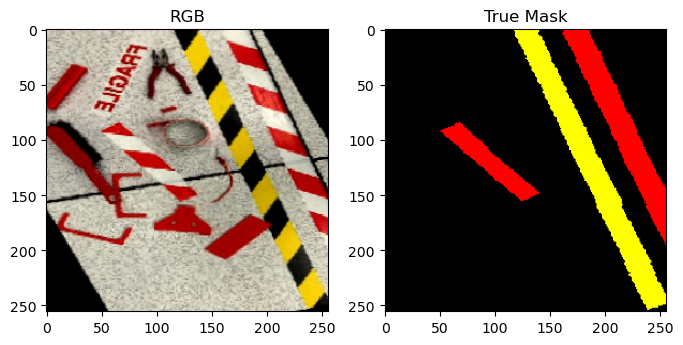

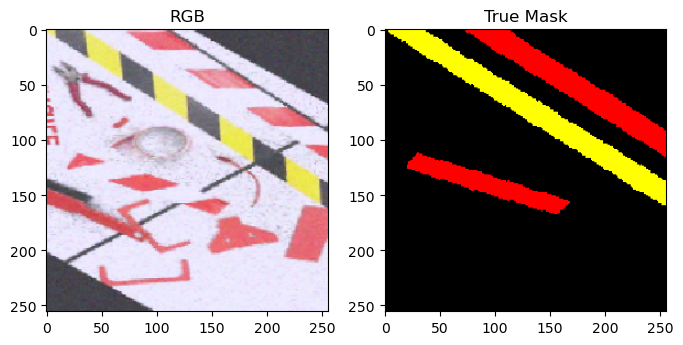

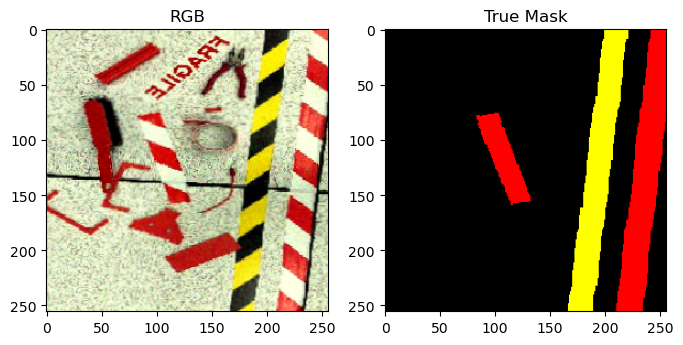

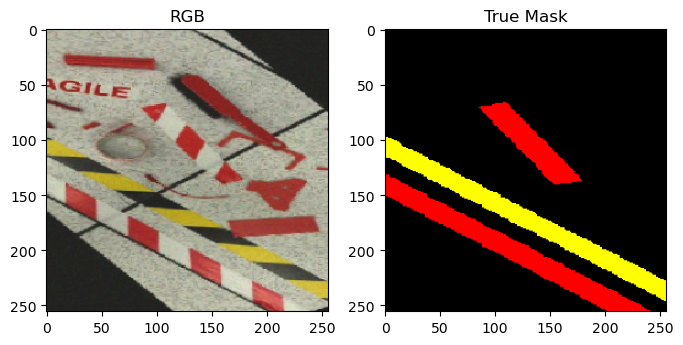

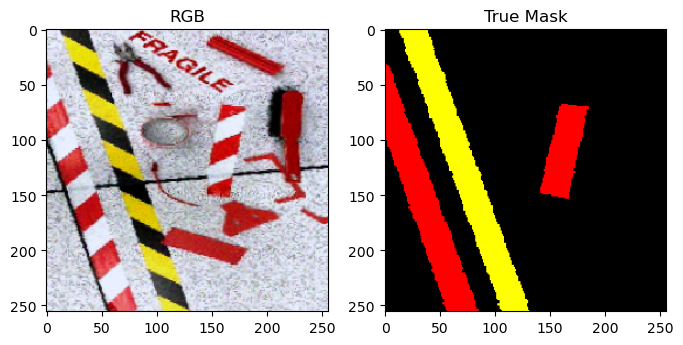

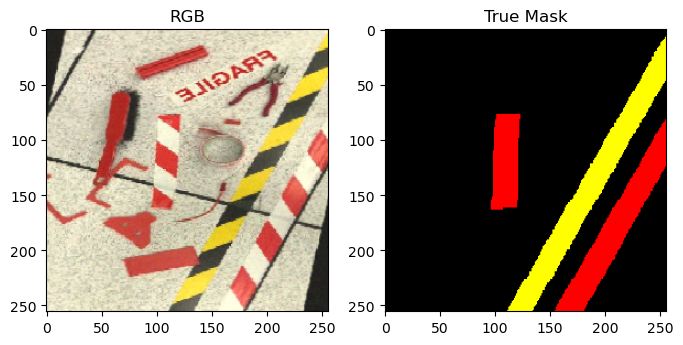

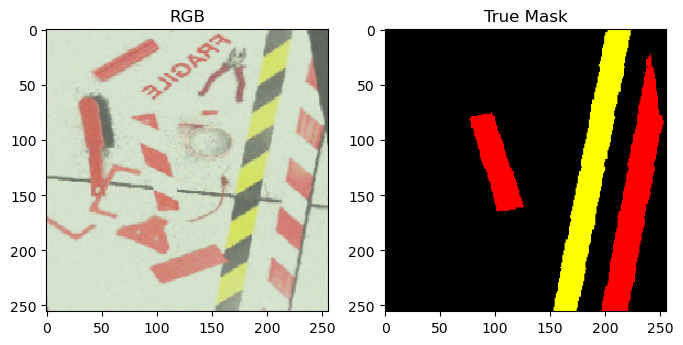

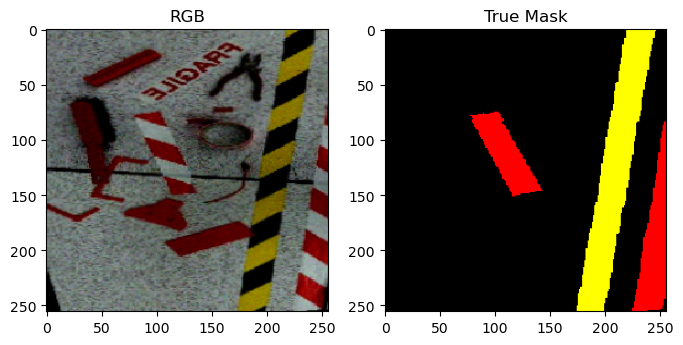

In [11]:
x_batch, y_batch = train_gen[0]
# x_batch, y_batch, sample_weights = train_gen[13]
# x_batch, y_batch = validate_gen[0]
print("X batch shape:", x_batch.shape)
print("Y batch shape:", y_batch.shape)
# print("sample_weights shape:", sample_weights.shape)

for i in range(x_batch.shape[0]):

    # Visualize the first image and mask
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(x_batch[i, ..., :3])
    plt.title('RGB')

    plt.subplot(1, 2, 2)
    # plt.imshow(np.argmax(y_batch[i], axis=-1), cmap='gray')  # Assuming one-hot encoded mask
    plt.imshow(class_ids_to_color_image(y_batch[i], color_map=class_ID_to_segmentation_color_mappings))
    # plt.imshow(y_batch[i, ..., 2])
    # plt.imshow(y_batch[i][..., 2])
    plt.title('True Mask')

plt.show()

## create deeplabv3+ model

In [19]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
    dropout_rate=0.1
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes, input_channels):
    # model_input = keras.Input(shape=(image_size, image_size, 3))
    # resnet50 = keras.applications.ResNet50(
    #     weights="imagenet", include_top=False, input_tensor=model_input
    # )
    model_input = keras.Input(shape=(*image_size, input_channels))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=image_size, num_classes=NUM_CLASSES, input_channels=3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [13]:
from tensorflow.keras import backend as K

def generalized_dice_loss(y_true, y_pred):
    smooth = 1e-5  # To avoid division by zero
    y_true_f = K.reshape(y_true, [-1, K.shape(y_true)[-1]])  # Flatten 'y_true' (excluding batch axis)
    y_pred_f = K.reshape(y_pred, [-1, K.shape(y_pred)[-1]])  # Flatten 'y_pred' (excluding batch axis)

    # Calculate class weights
    sum_true = K.sum(y_true_f, axis=0) + smooth
    weights = 1.0 / (sum_true ** 2)

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f, axis=0)
    union = K.sum(y_true_f, axis=0) + K.sum(y_pred_f, axis=0)
    
    # Compute the Generalized Dice coefficient
    numerator = K.sum(weights * intersection)
    denominator = K.sum(weights * (union + intersection))
    
    # Return Generalized Dice Loss
    return 1 - 2.0 * numerator / denominator


def combined_loss(y_true, y_pred):
    alpha = 0.5  # weight for Dice loss
    beta = 0.5  # weight for categorical cross-entropy loss
    return alpha * generalized_dice_loss(y_true, y_pred) + beta * keras.losses.CategoricalFocalCrossentropy(y_true, y_pred)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.92),
                #   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # for integer encoded targets (GT)
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False), # for one-hot encoded targets (GT)
                #   loss=generalized_dice_loss, # for one-hot encoded targets (GT)
                  # metrics=["accuracy", tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES)])
                  metrics=["accuracy"])

In [14]:
print(f'{len(model.layers)=}\n')
model.summary()

len(model.layers)=182

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                   

In [16]:
keras.utils.plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
checkpoint_dir = './checkpoints'
log_dir = './logs'

response = input('Old logs and checkpoints will be deleted now! Do you want to continue? [y|N]')
if response.lower() != 'y':
    print('Halting program, please interrupt cell execution. ')
    while True:
        pass

# delete old files
delete_directory(checkpoint_dir)
delete_directory(log_dir)

create_directory(checkpoint_dir)
create_directory(log_dir)

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.15)
        

class ImageLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, validation_data, model, update_freq=1):
        super().__init__()
        self.log_dir = log_dir
        self.validation_data = validation_data
        self.model = model
        self.update_freq = update_freq
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.update_freq == 0:
            # load and predict a validation batch
            x_val, y_val = next(iter(self.validation_data))
            predictions = self.model.predict(x_val, verbose=0)
            
            with self.writer.as_default():
                # draw n samples with uniform distances
                n = 5
                batch_size = x_val.shape[0]
                n = np.clip(n, a_min=1, a_max=batch_size)
                for i in [np.arange(batch_size)[i * (batch_size//n)] for i in range(n)]: 
                # for i in np.random.choice(np.arange(x_val.shape[0]), size=min(5, x_val.shape[0])): # Log up to 5 images
                    rgb_image = x_val[i, ..., :3]
                    depthmap = tf.expand_dims(x_val[i, ..., 3], axis=-1)
                    true_segmentation = class_ids_to_color_image(y_val[i], class_ID_to_segmentation_color_mappings)
                    predicted_segmentation = class_ids_to_color_image(predictions[i], class_ID_to_segmentation_color_mappings)

                    tf.summary.image(f"Validation Input Image {i}", tf.expand_dims(rgb_image, 0), step=epoch)
                    tf.summary.image(f"Validation Input Depthmap {i}", tf.expand_dims(depthmap, 0), step=epoch, max_outputs=1)
                    tf.summary.image(f"Validation True Mask {i}", tf.expand_dims(true_segmentation, 0), step=epoch, max_outputs=1)
                    tf.summary.image(f"Validation Predicted Mask {i}", tf.expand_dims(predicted_segmentation, 0), step=epoch, max_outputs=1)



earlyStopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model-ep{epoch:02d}-val_loss{val_loss:.2f}-val_accuracy{val_accuracy:.2f}', save_best_only=True, monitor='val_accuracy', mode='max')
# mcp_save_cb = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, verbose=1, epsilon=1e-4, mode='max')
tensor_board_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
image_logging_cb = ImageLoggingCallback(log_dir=log_dir, validation_data=validate_gen, model=model, update_freq=1)  # Custom callback
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

model_history = model.fit(
    train_gen, epochs=50, steps_per_epoch=len(train_gen), 
    validation_data=validate_gen, validation_steps=len(validate_gen),
    callbacks=[reduce_lr_loss_cb, tensor_board_cb, mcp_save_cb])
    # callbacks=[reduce_lr_loss_cb, tensor_board_cb, mcp_save_cb, lr_scheduler_cb])
    # callbacks=[earlyStopping_cb, mcp_save_cb, reduce_lr_loss_cb, tensor_board_cb])

The directory './checkpoints' has been deleted successfully.
The directory './logs' has been deleted successfully.
The directory './checkpoints' has been created successfully.
The directory './logs' has been created successfully.
Epoch 1/50


2024-01-28 15:54:08.889137: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 15:54:13.531866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-28 15:54:14.447729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-28 15:54:14.495153: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 15:54:16.403094: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef5b7495150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 15:54:16.403113: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070

115/115 [==============================] - ETA: 0s - loss: 88.4016 - accuracy: 0.8795INFO:tensorflow:Assets written to: ./checkpoints/model-ep01-val_loss79.13-val_accuracy0.92/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep01-val_loss79.13-val_accuracy0.92/assets


115/115 [==============================] - 49s 279ms/step - loss: 88.4016 - accuracy: 0.8795 - val_loss: 79.1267 - val_accuracy: 0.9154 - lr: 5.0000e-05
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 70.8370 - accuracy: 0.9025INFO:tensorflow:Assets written to: ./checkpoints/model-ep02-val_loss62.97-val_accuracy0.92/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep02-val_loss62.97-val_accuracy0.92/assets


115/115 [==============================] - 29s 257ms/step - loss: 70.8370 - accuracy: 0.9025 - val_loss: 62.9715 - val_accuracy: 0.9186 - lr: 5.0000e-05
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 56.0761 - accuracy: 0.9080INFO:tensorflow:Assets written to: ./checkpoints/model-ep03-val_loss49.54-val_accuracy0.92/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep03-val_loss49.54-val_accuracy0.92/assets


115/115 [==============================] - 30s 259ms/step - loss: 56.0761 - accuracy: 0.9080 - val_loss: 49.5402 - val_accuracy: 0.9205 - lr: 5.0000e-05
Epoch 4/50
115/115 [==============================] - 22s 195ms/step - loss: 43.8623 - accuracy: 0.9124 - val_loss: 38.5093 - val_accuracy: 0.9189 - lr: 5.0000e-05
Epoch 5/50
115/115 [==============================] - ETA: 0s - loss: 33.9401 - accuracy: 0.9180INFO:tensorflow:Assets written to: ./checkpoints/model-ep05-val_loss29.61-val_accuracy0.94/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep05-val_loss29.61-val_accuracy0.94/assets


115/115 [==============================] - 29s 252ms/step - loss: 33.9401 - accuracy: 0.9180 - val_loss: 29.6118 - val_accuracy: 0.9356 - lr: 5.0000e-05
Epoch 6/50
115/115 [==============================] - ETA: 0s - loss: 26.0366 - accuracy: 0.9231INFO:tensorflow:Assets written to: ./checkpoints/model-ep06-val_loss22.61-val_accuracy0.95/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep06-val_loss22.61-val_accuracy0.95/assets


115/115 [==============================] - 29s 251ms/step - loss: 26.0366 - accuracy: 0.9231 - val_loss: 22.6104 - val_accuracy: 0.9481 - lr: 5.0000e-05
Epoch 7/50
115/115 [==============================] - 22s 192ms/step - loss: 19.8632 - accuracy: 0.9284 - val_loss: 17.2592 - val_accuracy: 0.9376 - lr: 5.0000e-05
Epoch 8/50
115/115 [==============================] - 22s 194ms/step - loss: 15.1611 - accuracy: 0.9310 - val_loss: 13.2017 - val_accuracy: 0.9412 - lr: 5.0000e-05
Epoch 9/50
115/115 [==============================] - ETA: 0s - loss: 11.6530 - accuracy: 0.9350INFO:tensorflow:Assets written to: ./checkpoints/model-ep09-val_loss10.18-val_accuracy0.95/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep09-val_loss10.18-val_accuracy0.95/assets


115/115 [==============================] - 30s 258ms/step - loss: 11.6530 - accuracy: 0.9350 - val_loss: 10.1833 - val_accuracy: 0.9521 - lr: 5.0000e-05
Epoch 10/50
115/115 [==============================] - 22s 191ms/step - loss: 9.0827 - accuracy: 0.9383 - val_loss: 8.0155 - val_accuracy: 0.9498 - lr: 5.0000e-05
Epoch 11/50
115/115 [==============================] - 22s 194ms/step - loss: 7.2662 - accuracy: 0.9383 - val_loss: 6.5083 - val_accuracy: 0.9488 - lr: 5.0000e-05
Epoch 12/50
115/115 [==============================] - ETA: 0s - loss: 5.9668 - accuracy: 0.9426INFO:tensorflow:Assets written to: ./checkpoints/model-ep12-val_loss5.41-val_accuracy0.96/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep12-val_loss5.41-val_accuracy0.96/assets


115/115 [==============================] - 30s 258ms/step - loss: 5.9668 - accuracy: 0.9426 - val_loss: 5.4112 - val_accuracy: 0.9575 - lr: 5.0000e-05
Epoch 13/50
115/115 [==============================] - ETA: 0s - loss: 5.0421 - accuracy: 0.9451INFO:tensorflow:Assets written to: ./checkpoints/model-ep13-val_loss4.61-val_accuracy0.96/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep13-val_loss4.61-val_accuracy0.96/assets


115/115 [==============================] - 29s 252ms/step - loss: 5.0421 - accuracy: 0.9451 - val_loss: 4.6149 - val_accuracy: 0.9621 - lr: 5.0000e-05
Epoch 14/50
115/115 [==============================] - 22s 193ms/step - loss: 4.3444 - accuracy: 0.9470 - val_loss: 4.0545 - val_accuracy: 0.9429 - lr: 5.0000e-05
Epoch 15/50
115/115 [==============================] - 22s 194ms/step - loss: 3.7598 - accuracy: 0.9498 - val_loss: 3.4670 - val_accuracy: 0.9619 - lr: 5.0000e-05
Epoch 16/50
115/115 [==============================] - 22s 193ms/step - loss: 3.2906 - accuracy: 0.9519 - val_loss: 3.0358 - val_accuracy: 0.9589 - lr: 5.0000e-05
Epoch 17/50
115/115 [==============================] - ETA: 0s - loss: 2.8657 - accuracy: 0.9539INFO:tensorflow:Assets written to: ./checkpoints/model-ep17-val_loss2.67-val_accuracy0.96/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep17-val_loss2.67-val_accuracy0.96/assets


115/115 [==============================] - 30s 260ms/step - loss: 2.8657 - accuracy: 0.9539 - val_loss: 2.6651 - val_accuracy: 0.9636 - lr: 5.0000e-05
Epoch 18/50
115/115 [==============================] - 22s 194ms/step - loss: 2.5081 - accuracy: 0.9568 - val_loss: 2.3481 - val_accuracy: 0.9600 - lr: 5.0000e-05
Epoch 19/50
115/115 [==============================] - 22s 190ms/step - loss: 2.2148 - accuracy: 0.9585 - val_loss: 2.0502 - val_accuracy: 0.9604 - lr: 5.0000e-05
Epoch 20/50
115/115 [==============================] - 22s 191ms/step - loss: 1.9444 - accuracy: 0.9601 - val_loss: 1.8193 - val_accuracy: 0.9607 - lr: 5.0000e-05
Epoch 21/50
115/115 [==============================] - 22s 192ms/step - loss: 1.7042 - accuracy: 0.9629 - val_loss: 1.5908 - val_accuracy: 0.9628 - lr: 5.0000e-05
Epoch 22/50
115/115 [==============================] - ETA: 0s - loss: 1.5009 - accuracy: 0.9640INFO:tensorflow:Assets written to: ./checkpoints/model-ep22-val_loss1.38-val_accuracy0.97/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep22-val_loss1.38-val_accuracy0.97/assets


115/115 [==============================] - 29s 251ms/step - loss: 1.5009 - accuracy: 0.9640 - val_loss: 1.3832 - val_accuracy: 0.9736 - lr: 5.0000e-05
Epoch 23/50
115/115 [==============================] - 22s 188ms/step - loss: 1.3188 - accuracy: 0.9659 - val_loss: 1.2220 - val_accuracy: 0.9683 - lr: 5.0000e-05
Epoch 24/50
115/115 [==============================] - 22s 190ms/step - loss: 1.1549 - accuracy: 0.9671 - val_loss: 1.0751 - val_accuracy: 0.9694 - lr: 5.0000e-05
Epoch 25/50
115/115 [==============================] - ETA: 0s - loss: 1.0114 - accuracy: 0.9690INFO:tensorflow:Assets written to: ./checkpoints/model-ep25-val_loss0.93-val_accuracy0.97/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep25-val_loss0.93-val_accuracy0.97/assets


115/115 [==============================] - 28s 248ms/step - loss: 1.0114 - accuracy: 0.9690 - val_loss: 0.9310 - val_accuracy: 0.9737 - lr: 5.0000e-05
Epoch 26/50
115/115 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.9697INFO:tensorflow:Assets written to: ./checkpoints/model-ep26-val_loss0.81-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep26-val_loss0.81-val_accuracy0.98/assets


115/115 [==============================] - 28s 245ms/step - loss: 0.8862 - accuracy: 0.9697 - val_loss: 0.8074 - val_accuracy: 0.9772 - lr: 5.0000e-05
Epoch 27/50
115/115 [==============================] - 22s 191ms/step - loss: 0.7755 - accuracy: 0.9705 - val_loss: 0.7199 - val_accuracy: 0.9726 - lr: 5.0000e-05
Epoch 28/50
115/115 [==============================] - 22s 189ms/step - loss: 0.6759 - accuracy: 0.9722 - val_loss: 0.6340 - val_accuracy: 0.9723 - lr: 5.0000e-05
Epoch 29/50
115/115 [==============================] - 22s 194ms/step - loss: 0.6014 - accuracy: 0.9711 - val_loss: 0.5609 - val_accuracy: 0.9713 - lr: 5.0000e-05
Epoch 30/50
115/115 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.9734INFO:tensorflow:Assets written to: ./checkpoints/model-ep30-val_loss0.47-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep30-val_loss0.47-val_accuracy0.98/assets


115/115 [==============================] - 29s 256ms/step - loss: 0.5182 - accuracy: 0.9734 - val_loss: 0.4692 - val_accuracy: 0.9795 - lr: 5.0000e-05
Epoch 31/50
115/115 [==============================] - 22s 191ms/step - loss: 0.4583 - accuracy: 0.9737 - val_loss: 0.4177 - val_accuracy: 0.9781 - lr: 5.0000e-05
Epoch 32/50
115/115 [==============================] - 22s 194ms/step - loss: 0.4005 - accuracy: 0.9751 - val_loss: 0.3706 - val_accuracy: 0.9758 - lr: 5.0000e-05
Epoch 33/50
115/115 [==============================] - 23s 197ms/step - loss: 0.3574 - accuracy: 0.9748 - val_loss: 0.3252 - val_accuracy: 0.9795 - lr: 5.0000e-05
Epoch 34/50
115/115 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.9758INFO:tensorflow:Assets written to: ./checkpoints/model-ep34-val_loss0.29-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep34-val_loss0.29-val_accuracy0.98/assets


115/115 [==============================] - 29s 256ms/step - loss: 0.3167 - accuracy: 0.9758 - val_loss: 0.2895 - val_accuracy: 0.9802 - lr: 5.0000e-05
Epoch 35/50
115/115 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9769INFO:tensorflow:Assets written to: ./checkpoints/model-ep35-val_loss0.26-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep35-val_loss0.26-val_accuracy0.98/assets


115/115 [==============================] - 30s 259ms/step - loss: 0.2806 - accuracy: 0.9769 - val_loss: 0.2582 - val_accuracy: 0.9811 - lr: 5.0000e-05
Epoch 36/50
115/115 [==============================] - 23s 197ms/step - loss: 0.2570 - accuracy: 0.9770 - val_loss: 0.2384 - val_accuracy: 0.9801 - lr: 5.0000e-05
Epoch 37/50
115/115 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9777INFO:tensorflow:Assets written to: ./checkpoints/model-ep37-val_loss0.22-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep37-val_loss0.22-val_accuracy0.98/assets


115/115 [==============================] - 30s 260ms/step - loss: 0.2352 - accuracy: 0.9777 - val_loss: 0.2159 - val_accuracy: 0.9818 - lr: 5.0000e-05
Epoch 38/50
115/115 [==============================] - 22s 193ms/step - loss: 0.2190 - accuracy: 0.9778 - val_loss: 0.2085 - val_accuracy: 0.9796 - lr: 5.0000e-05
Epoch 39/50
115/115 [==============================] - 22s 195ms/step - loss: 0.2070 - accuracy: 0.9778 - val_loss: 0.2052 - val_accuracy: 0.9784 - lr: 5.0000e-05
Epoch 40/50
115/115 [==============================] - 23s 196ms/step - loss: 0.1951 - accuracy: 0.9785 - val_loss: 0.2112 - val_accuracy: 0.9719 - lr: 5.0000e-05
Epoch 41/50
115/115 [==============================] - 22s 193ms/step - loss: 0.1829 - accuracy: 0.9791 - val_loss: 0.1937 - val_accuracy: 0.9745 - lr: 5.0000e-05
Epoch 42/50
115/115 [==============================] - 23s 198ms/step - loss: 0.1725 - accuracy: 0.9801 - val_loss: 0.1688 - val_accuracy: 0.9810 - lr: 5.0000e-05
Epoch 43/50
115/115 [=============

INFO:tensorflow:Assets written to: ./checkpoints/model-ep43-val_loss0.16-val_accuracy0.98/assets


115/115 [==============================] - 29s 256ms/step - loss: 0.1655 - accuracy: 0.9801 - val_loss: 0.1561 - val_accuracy: 0.9832 - lr: 5.0000e-05
Epoch 44/50
115/115 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9799INFO:tensorflow:Assets written to: ./checkpoints/model-ep44-val_loss0.15-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep44-val_loss0.15-val_accuracy0.98/assets


115/115 [==============================] - 29s 249ms/step - loss: 0.1596 - accuracy: 0.9799 - val_loss: 0.1478 - val_accuracy: 0.9834 - lr: 5.0000e-05
Epoch 45/50
115/115 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9801INFO:tensorflow:Assets written to: ./checkpoints/model-ep45-val_loss0.14-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep45-val_loss0.14-val_accuracy0.98/assets


115/115 [==============================] - 30s 259ms/step - loss: 0.1543 - accuracy: 0.9801 - val_loss: 0.1419 - val_accuracy: 0.9845 - lr: 5.0000e-05
Epoch 46/50
115/115 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9810INFO:tensorflow:Assets written to: ./checkpoints/model-ep46-val_loss0.13-val_accuracy0.98/assets


INFO:tensorflow:Assets written to: ./checkpoints/model-ep46-val_loss0.13-val_accuracy0.98/assets


115/115 [==============================] - 30s 258ms/step - loss: 0.1464 - accuracy: 0.9810 - val_loss: 0.1334 - val_accuracy: 0.9850 - lr: 5.0000e-05
Epoch 47/50
115/115 [==============================] - 23s 199ms/step - loss: 0.1395 - accuracy: 0.9815 - val_loss: 0.1342 - val_accuracy: 0.9840 - lr: 5.0000e-05
Epoch 48/50
115/115 [==============================] - 22s 195ms/step - loss: 0.1360 - accuracy: 0.9814 - val_loss: 0.1407 - val_accuracy: 0.9786 - lr: 5.0000e-05
Epoch 49/50
115/115 [==============================] - 22s 193ms/step - loss: 0.1313 - accuracy: 0.9814 - val_loss: 0.1266 - val_accuracy: 0.9839 - lr: 5.0000e-05
Epoch 50/50
115/115 [==============================] - 22s 194ms/step - loss: 0.1263 - accuracy: 0.9819 - val_loss: 0.1193 - val_accuracy: 0.9843 - lr: 5.0000e-05


In [21]:
model.load_weights('./checkpoints/model-ep46-val_loss0.13-val_accuracy0.98/')
# model.load_weights('./models/deeplabv3Plus_rgb_ep_50_augmented/')

2024-01-28 22:33:27.584043: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./checkpoints/model-ep46-val_loss0.13-val_accuracy0.98/: FAILED_PRECONDITION: checkpoints/model-ep46-val_loss0.13-val_accuracy0.98; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [12]:


# model.save('./models/unet_rgbd_ep_50_augmented_2')
# model.save('./models/deeplabv3Plus_rgb_ep_50_augmented')

INFO:tensorflow:Assets written to: ./models/deeplabv3Plus_rgb_ep_50_augmented/assets


INFO:tensorflow:Assets written to: ./models/deeplabv3Plus_rgb_ep_50_augmented/assets


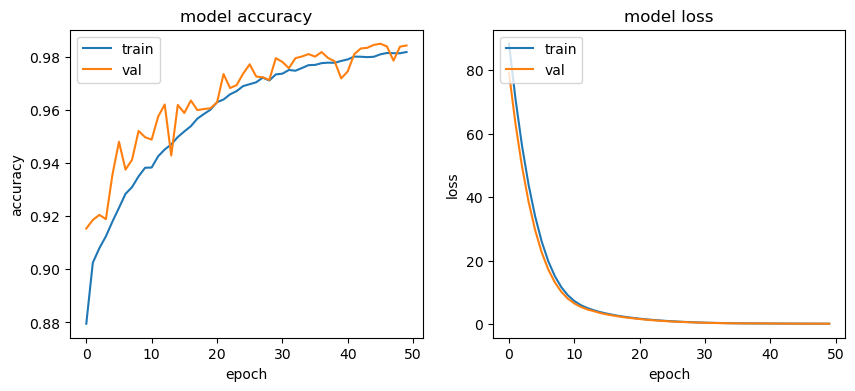

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

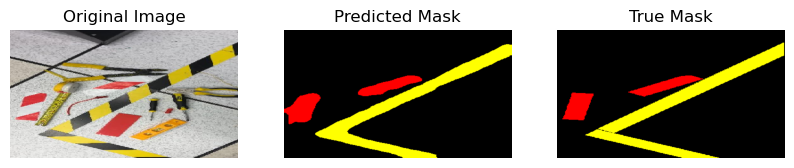

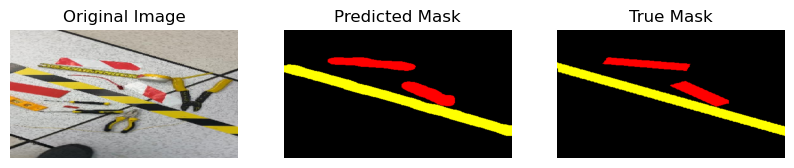

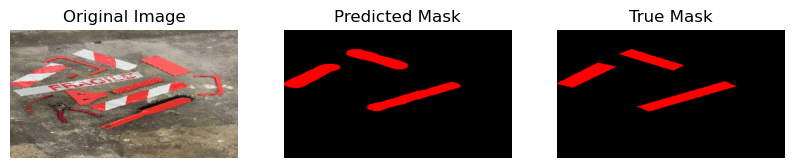

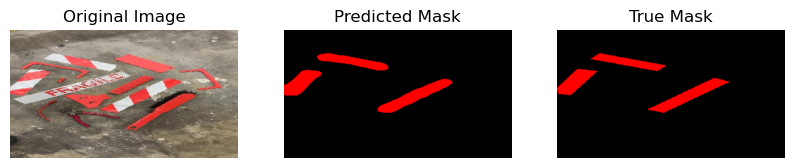

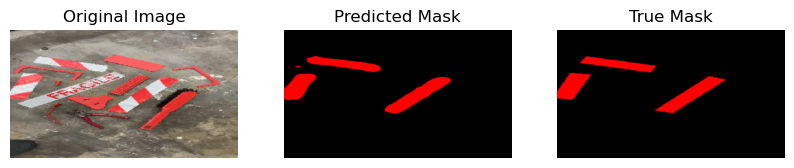

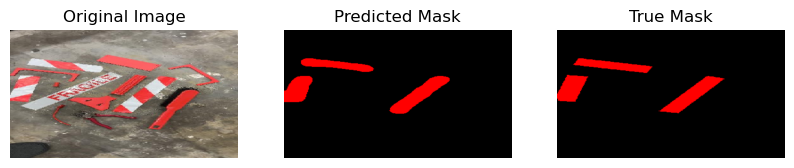

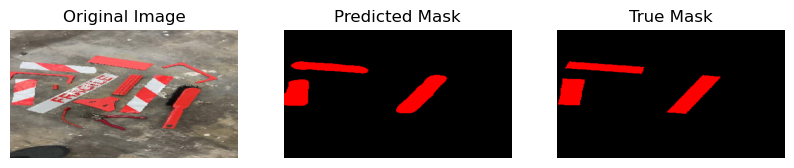

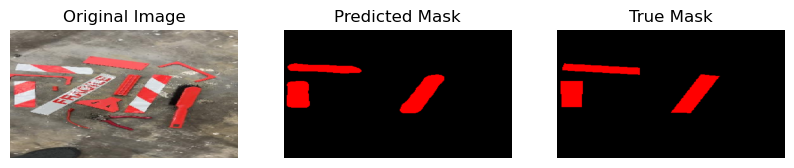

In [23]:
x, y = test_gen.__getitem__(5)

prediction = model.predict(x, batch_size=x.shape[0], steps=1)

# rgb_predictions = [prediction_to_color_image(pred, class_ID_to_segmentation_color_mappings, resize_to=(1920, 1080)) for pred in prediction]
# rgb_ground_truths  = [class_ids_to_color_image(gt, class_ID_to_segmentation_color_mappings, resize_to=(1920, 1080)) for gt in y]
rgb_predictions = [class_ids_to_color_image(pred, class_ID_to_segmentation_color_mappings, resize_to=(1920, 1080)) for pred in prediction]
rgb_ground_truths  = [class_ids_to_color_image(gt, class_ID_to_segmentation_color_mappings, resize_to=(1920, 1080)) for gt in y]

for x, output, rgb_prediction, rgb_ground_truth in zip(x, y, rgb_predictions, rgb_ground_truths):

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    # original_image = cv2.imread(test_image_path)
    # original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(x[..., :3], (1920, 1080), interpolation=cv2.INTER_NEAREST)
    plt.imshow(original_image)
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(rgb_prediction)
    plt.axis('off')

    # plt.subplot(1, 4, 2)
    # plt.title("True Tire Mask ")
    # plt.imshow(output[:, :, 1]*255)
    # plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Mask")
    plt.imshow(rgb_ground_truth )
    plt.axis('off')

plt.show()